In [1]:
import os
import sys
import shutil
import subprocess
import pandas as pd
from lumpyrem import run
import flopy
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # Suppress deprecation warnings

In [2]:
org_model_ws = os.path.join('..', 'temp_ml_obs')
os.listdir(org_model_ws)

['pest', 'runmodel']

In [3]:
tmp_model_ws = os.path.join('..', 'temp_ml_calib')
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['pest', 'runmodel']

In [4]:
pest_ws = os.path.join(tmp_model_ws, 'pest')

In [5]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

#### Windows runmodel-script:

In [6]:
write_script(os.path.join(pest_ws, 'runmodel.bat'), [
'''
@echo off
Rem ###################################
Rem Some intermediate files are deleted as a precaution.
Rem Delete MF6 computed output
Rem ###################################
cd %~dp0..\\runmodel\\model
del /s *.csv
del /s ghb_new.ts
del /s rch_new.ts
Rem ###################################
Rem Do not remove sfr_reach1_inflow.ts!
Rem ###################################

Rem ###################################
Rem Delete Luprem computed output
Rem ###################################
cd %~dp0..\\runmodel\\lumprem
del /s *.out
del /s *.ts

Rem ###################################
Rem Run LUMPREM and copy files into MF6 rundir
Rem ###################################
lumprem2 lr_lu1.in lr_lu1.out
lumprem2 lr_red.in lr_red.out
lumprem2 lr_yellow.in lr_yellow.out
lumprem2 lr_green.in lr_green.out
lumprem2 lr_blue.in lr_blue.out

echo rch.ts.in | lr2series
echo ghb.ts.in | lr2series

ts6proc ts6ghb.in
ts6proc ts6rch.in

copy ghb_new.ts "..\model"
copy rch_new.ts "..\model"

Rem ###################################
Rem PLPROC assigns parameters from ppoints
Rem ###################################
cd %~dp0..\\runmodel\\preproc\\
plproc plproc_kh.dat
plproc plproc_sy.dat
plproc plproc_rchmul.dat
plproc plproc_sfr.dat
plproc plproc_ghb.dat
python sfr_rtpmodel.py
python ghb_multiplier.py
python sfr_rainf_evapo_multiplier.py

Rem ###################################
Rem The MF6 model is run
Rem ###################################
cd %~dp0..\\runmodel\\model\\
mf6 mfsim.nam

Rem ###################################
Rem The observations are postprocessed
Rem ###################################
cd  %~dp0..\\runmodel\\postproc\\
olproc olproc.in 1
olproc olproc-pred.in 1

Rem ###################################
Rem Return the command line to the working folder
Rem ###################################
cd %~dp0.\\

'''
])

In [7]:
write_script(os.path.join(pest_ws, 'runmodel.sh'), [
'''
#!/bin/bash
# Remove old MF6 files
cd ${0%/*}./runmodel/model
rm -f *.csv
rm -f ghb_new.ts
rm -f rch_new.ts
# Do not remove sfr_reach1_inflow.ts!

# Remove old LR files
cd ../lumprem
rm -f *.out
rm -f *.ts

# Run LUMPREM models
./lumprem2 lr_lu1.in lr_lu1.out
./lumprem2 lr_red.in lr_red.out
./lumprem2 lr_yellow.in lr_yellow.out
./lumprem2 lr_green.in lr_green.out
./lumprem2 lr_blue.in lr_blue.out

# Convert LR output to TS
echo rch.ts.in | ./lr2series
echo ghb.ts.in | ./lr2series

# Postprocess TS using TS6PROC
./ts6proc ts6ghb.in
./ts6proc ts6rch.in

# Copy TS-files to MF6 dir
cp ghb_new.ts ../model
cp rch_new.ts ../model

# Run PLPROC
cd ../preproc
./plproc plproc_kh.dat
./plproc plproc_sy.dat
./plproc plproc_rchmul.dat
./plproc plproc_sfr.dat
./plproc plproc_ghb.dat
python3 sfr_rtpmodel.py
python3 ghb_multiplier.py
python3 sfr_rainf_evapo_multiplier.py

# Run MF6 model
cd ../model
./mf6 mfsim.nam

# Postprocess observations
# Run MF6 model
cd ../postproc
./olproc olproc.in 1
./olproc olproc-pred.in 1

#Rem ###################################
#Rem Return the command line to the working folder
#Rem ###################################
#cd %~dp0.\\
# is this necessary on linux?

'''
])

### Make copy of calibration file

In [8]:
os.listdir(tmp_model_ws)

['pest', 'runmodel']

In [9]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'r') as file:
    calib1 = file.readlines()

### Change NOPTMAX from 50 to 0:

In [10]:
temp_row = calib1[8].split()
display(temp_row)

['50', '0.005', '4', '4', '0.005', '4']

In [11]:
temp_row[0] = '0'
temp_row[-1] = f'{temp_row[-1]}\n'
display(temp_row)

['0', '0.005', '4', '4', '0.005', '4\n']

In [12]:
new_row = ' '.join(temp_row)
display(new_row)

'0 0.005 4 4 0.005 4\n'

In [13]:
calib1[8] = new_row

### Add model command line

In [14]:
mlcl_strt = calib1.index('* model command line\n') + 1
mlcl_stop = calib1.index('* model input/output\n')

In [15]:
calib1[mlcl_strt:mlcl_stop] = 'runmodel.bat\n'

### Write file

In [16]:
# Write the file out again
with open(os.path.join(pest_ws, 'calib1.pst'), 'w') as file:
    for line in calib1:
        file.write(line)

### Run model once to weight for visibility

Copy relevant binaries:

In [17]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries

In [18]:
os.listdir(bins_pth)

['agent_hp.exe',
 'gridgen.exe',
 'libiomp5md.dll',
 'mf6.exe',
 'pestpp-ies.exe',
 'pest_hp_mkl.exe',
 'triangle.exe']

In [19]:
copyfiles = ['agent_hp.exe', 'libiomp5md.dll', 'pest_hp_mkl.exe', 'mf6.exe']

In [20]:
for file in copyfiles:
    shutil.copyfile(os.path.join(bins_pth, file), os.path.join(pest_ws, file))

In [21]:
agent_dir = os.path.join(tmp_model_ws ,'agent_dir')
if os.path.exists(agent_dir):
    shutil.rmtree(agent_dir)
os.mkdir(agent_dir)

In [22]:
agent0_dir = os.path.join(agent_dir ,'agent0')
if os.path.exists(agent0_dir):
    shutil.rmtree(agent0_dir)

In [23]:
for folder in ['pest', 'runmodel']:
    shutil.copytree(os.path.join(tmp_model_ws, folder), os.path.join(agent0_dir, folder), dirs_exist_ok=True)

In [24]:
p = subprocess.run(['i64pestchek', 'calib1.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 No errors encountered.

 Warnings ----->
 NOPTMAX provided as zero. No optimisation iterations will be carried out; 
   objective function and residuals will be recorded for initial parameter 
   estimates only.
 MAXSING in the singular value decomposition section is greater than the 
   number of adjustable parameters.



---

Manually run `pest_hp_mkl calib1.pst /h :4004` in pest_ws

Manually run `agent_hp calib1.pst /h %computername%:4004` in agent0_dir

local path (my machine): `set PATH=%PATH%;C:\Users\nat12nho\Documents\Development\repos\hagfors_gwm\bins\win`

---

In [25]:
agent_ml, ml_name = os.path.join(agent0_dir, 'runmodel', 'model'), 'hagfors_1'
sim_agent = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), agent_ml)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package rch...
    loading package sto...
    loading package oc...
    loading package npf...
    loading package ic...
    loading package sfr...
    loading package obs...
    loading package ghb...
  loading ims package hagfors_1...


In [26]:
gwf = sim_agent.get_model(ml_name)

In [27]:
# get the specific discharge from the cell budget file
cbb_file = os.path.join(agent_ml, f'{ml_name}.cbb')
cbb = flopy.utils.CellBudgetFile(cbb_file)

# get the head from the head file
head_file = os.path.join(agent_ml, f'{ml_name}.hds')
head = flopy.utils.HeadFile(head_file)
hdata = head.get_alldata()

No handles with labels found to put in legend.


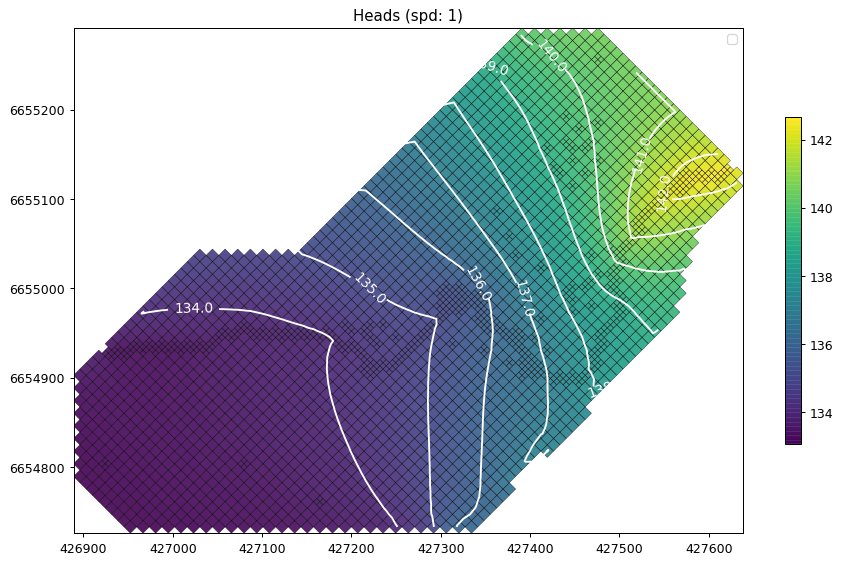

In [28]:
spd = 1

fig = plt.figure(figsize=(12, 12), dpi=90)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25, color='k')
quadmesh = mapview.plot_array(a=hdata[spd], alpha=0.9, masked_values=[1e30])
plt.colorbar(quadmesh, shrink=0.4);

levels = np.arange(130, 145, 1.0)
contour_set = mapview.contour_array(hdata[spd], levels=levels, colors='white')
plt.clabel(contour_set, fmt="%.1f", colors='white', fontsize=11)


plt.title(f'Heads (spd: {spd})')
plt.legend()
plt.show()

In [29]:
hdata[0][0][0]

array([133.40055636, 133.50996374, 133.54628199, ..., 137.2949434 ,
       137.38564845, 137.5261642 ])

In [30]:
(gwf.disv.top.get_data() - hdata[200][0][0]).min()

0.007500950011007035

Weight for visibility (lumpyrem.run process does not seem to work with tpl2pst, tempchek, pestchek, pest_hp, pwtadj1. Use `subprocess` instead):

In [31]:
p = subprocess.run(['pwtadj1', 'calib1.pst', 'calib1-wt.pst', '1000'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 PWTADJ1 version 17.3. Watermark Numerical Computing.

 - reading PEST control file calib1.pst for first time...
 - file calib1.pst read ok.

 - reading PEST run record file calib1.rec...
 - file calib1.rec read ok.

 - re-reading file calib1.pst and writing file calib1-wt.pst...
 - file calib1.pst read ok.
 - file calib1-wt.pst written ok.

 obsevation group ">@dts" as contribution to objective function of this 
 group is zero.
 obsevation group ">@of" as contribution to objective function of this 
 group is zero.
 obsevation group "pfluxb" as contribution to objective function of this 
 group is zero.
 obsevation group "pofb" as contribution to objective function of this 
 group is zero.
 obsevation group "pfluxr" as contribution to objective function of this 
 group is zero.
 obsevation group "pofr" as contribution to objective function of this 
 group is zero.



Change NOPTMAX from 50 to 0:

In [32]:
with open(os.path.join(pest_ws, 'calib1-wt.pst'), 'r') as file:
    calib1_wt = file.readlines()

In [33]:
temp_row = calib1_wt[8].split()
display(temp_row)
temp_row[0] = '0'
temp_row[-1] = f'{temp_row[-1]}\n'
display(temp_row)
new_row = ' '.join(temp_row)
display(new_row)
calib1_wt[8] = new_row

['50', '0.005', '4', '4', '0.005', '4']

['0', '0.005', '4', '4', '0.005', '4\n']

'0 0.005 4 4 0.005 4\n'

In [34]:
# Write the file out again
with open(os.path.join(pest_ws, 'calib1-wt.pst'), 'w') as file:
    for line in calib1_wt:
        file.write(line)

Copy `calib1-wt.pst` to agent0:

In [35]:
shutil.copyfile(os.path.join(pest_ws, 'calib1-wt.pst'), os.path.join(agent0_dir, 'pest', 'calib1-wt.pst'))

'..\\temp_ml_calib\\agent_dir\\agent0\\pest\\calib1-wt.pst'

In [36]:
p = subprocess.run(['i64pestchek', 'calib1-wt.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 No errors encountered.

 Warnings ----->
 NOPTMAX provided as zero. No optimisation iterations will be carried out; 
   objective function and residuals will be recorded for initial parameter 
   estimates only.
 MAXSING in the singular value decomposition section is greater than the 
   number of adjustable parameters.



Manually add weight for dts

---

Manually run `pest_hp_mkl calib1-wt.pst /h :4004` in pest_ws

Manually run `agent_hp calib1-wt.pst /h %computername%:4004` in agent0_dir

---

### Adding Tikhonov Regularization

In [37]:
p = subprocess.run(['addreg1', 'calib1-wt.pst', 'calib1-wt-reg.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 ADDREG1 version 17.3. Watermark Numerical Computing.
 - file calib1-wt.pst read ok.
 - file calib1-wt-reg.pst written ok.



In [38]:
p = subprocess.run(['i64pestchek', 'calib1-wt-reg.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 No errors encountered.

 Warnings ----->
 NOPTMAX provided as zero. No optimisation iterations will be carried out; 
   objective function and residuals will be recorded for initial parameter 
   estimates only.
 MAXSING in the singular value decomposition section is greater than the 
   number of adjustable parameters.



#### ADD COVARIANCE MATRICES

In [39]:
with open(os.path.join(pest_ws, 'calib1-wt-reg.pst'), 'r') as file:
    pestfile = file.readlines()

In [40]:
pestfile

['pcf\n',
 '* control data\n',
 'restart regularisation\n',
 '    1709  172059      26    1709      41\n',
 '13 15 single point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 '0 0.005 4 4 0.005 4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 paraboli

In [41]:
priordata_start = pestfile.index('* prior information\n') + 1
priordata_stop = pestfile.index('* regularisation\n')

In [42]:
priordata_df = pd.DataFrame(pestfile[priordata_start:priordata_stop]) # read df

Extract all regularization OBGNME from the priordata section:

In [43]:
regul_obgnme = pd.Series([i.split()[-1] for i in priordata_df.iloc[:,0]]).unique()

In [44]:
print(regul_obgnme)

['regul_ghbcbl' 'regul_ghbcgr' 'regul_ghbcre' 'regul_ghbcye'
 'regul_ghbmul' 'regul_khpp' 'regul_lr_cf' 'regul_lr_f1' 'regul_lr_f2'
 'regul_lr_gam' 'regul_lr_ks' 'regul_lr_m' 'regul_lr_off' 'regul_lr_pow'
 'regul_rchmul' 'regul_sfrbth' 'regul_sfrgrd' 'regul_sfrinf'
 'regul_sfrman' 'regul_sfrrhk' 'regul_sfrtpe' 'regul_sfrtpo'
 'regul_sfrtps' 'regul_sfrwid' 'regul_sr1mul' 'regul_sypp']


Print all covariance matrices:

In [45]:
preproc_ws = os.path.join(tmp_model_ws, 'runmodel', 'preproc')

In [46]:
for file in os.listdir(preproc_ws):
    if '.mat' in file:
        print(file)

cov_cond.mat
cov_ghb_blue.mat
cov_ghb_green.mat
cov_ghb_red.mat
cov_ghb_yellow.mat
cov_sfr.mat
cov_sfr_inf1.mat
cov_sy_rchmul.mat


Use covariance matrices with regularisation groups for spatial parameters:

In [47]:
write_script(os.path.join(pest_ws, 'covmatfile.in'), [
'''
regul_ghbcye ..\\runmodel\\preproc\\cov_ghb_yellow.mat
regul_ghbcbl ..\\runmodel\\preproc\\cov_ghb_blue.mat
regul_ghbcgr ..\\runmodel\\preproc\\cov_ghb_green.mat
regul_ghbcre ..\\runmodel\\preproc\\cov_ghb_red.mat
regul_sfrwid ..\\runmodel\\preproc\\cov_sfr.mat
regul_sfrgrd ..\\runmodel\\preproc\\cov_sfr.mat
regul_sfrbth ..\\runmodel\\preproc\\cov_sfr.mat
regul_sfrrhk ..\\runmodel\\preproc\\cov_sfr.mat
regul_sfrman ..\\runmodel\\preproc\\cov_sfr.mat
regul_khpp ..\\runmodel\\preproc\\cov_cond.mat
regul_sypp ..\\runmodel\\preproc\\cov_sy_rchmul.mat
regul_rchmul ..\\runmodel\\preproc\\cov_sy_rchmul.mat
regul_sfrinf ..\\runmodel\\preproc\\cov_sfr_inf1.mat
'''
])

In [48]:
p = subprocess.run(['addcovmat', 'calib1-wt-reg.pst', 'covmatfile.in', 'calib1-wt-cov.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


ADDCOVMAT Version 17.3. Watermark Numerical Computing.

- 13 observation groups featured in file 
- file calib1-wt-reg.pst read ok.
- file calib1-wt-cov.pst written ok.



In [49]:
p = subprocess.run(['i64pestchek', 'calib1-wt-cov.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 No errors encountered.

 Warnings ----->
 NOPTMAX provided as zero. No optimisation iterations will be carried out; 
   objective function and residuals will be recorded for initial parameter 
   estimates only.
 MAXSING in the singular value decomposition section is greater than the 
   number of adjustable parameters.



#### Turn off SVD:

In [50]:
with open(os.path.join(pest_ws, 'calib1-wt-cov.pst'), 'r') as file:
    pestfile = file.readlines()

In [51]:
svd_mode_index = pestfile.index('* singular value decomposition\n') + 1

In [52]:
pestfile[svd_mode_index]

'1\n'

In [53]:
pestfile[svd_mode_index] = '0\n'

In [54]:
pestfile[svd_mode_index]

'0\n'

#### Add LSQR:

In [55]:
temp_row = pestfile[3].split()
display(temp_row)

['1709', '172059', '26', '1709', '41']

In [56]:
npar = int(temp_row[0])
npar

1709

In [57]:
LSQR_ITNLIM = str(npar*4)
LSQR_ITNLIM

'6836'

In [58]:
lsqr_row3 = f'1.0E-4 1.0E-4 1000.0 {LSQR_ITNLIM}\n'

In [59]:
lsqr_row3

'1.0E-4 1.0E-4 1000.0 6836\n'

In [60]:
lsqr = ['* lsqr\n', '1\n', lsqr_row3, '1\n']

In [61]:
pestfile

['pcf\n',
 '* control data\n',
 'restart regularisation\n',
 '    1709  172059      26    1709      41\n',
 '13 15 single point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 '0 0.005 4 4 0.005 4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '0\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 2 parabolic\n',
 'lr_off relative 0.015 0.0 switch 2 paraboli

In [62]:
lsqr_strt, lsqr_stop = pestfile.index('* parameter groups\n'), pestfile.index('* parameter groups\n')

In [63]:
pestfile[lsqr_strt:lsqr_stop] = lsqr

In [64]:
pestfile

['pcf\n',
 '* control data\n',
 'restart regularisation\n',
 '    1709  172059      26    1709      41\n',
 '13 15 single point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 '0 0.005 4 4 0.005 4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '0\n',
 '  5000  5e-7\n',
 '0\n',
 '* lsqr\n',
 '1\n',
 '1.0E-4 1.0E-4 1000.0 6836\n',
 '1\n',
 '* parameter groups\n',
 'ghbcbl relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcgr relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcre relative 0.015 0.0 switch 2 parabolic\n',
 'ghbcye relative 0.015 0.0 switch 2 parabolic\n',
 'ghbmul relative 0.015 0.0 switch 2 parabolic\n',
 'khpp relative 0.015 0.0 switch 2 parabolic\n',
 'lr_cf relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f1 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_f2 relative 0.015 0.0 switch 2 parabolic\n',
 'lr_gam relative 0.015 0.0 switch 2 parabolic\n',
 'lr_ks relative 0.015 0.0 switch 2 parabolic\n',
 'lr_m relative 0.015 0.0 switch 

#### Adjust uptestmin:

In [65]:
temp_row = pestfile[5].split()
display(temp_row)

['10.0', '-3.0', '0.3', '0.03', '10', 'lamforgive']

In [66]:
temp_row.append('uptestmin=30\n') #why 30?

In [67]:
temp_row

['10.0', '-3.0', '0.3', '0.03', '10', 'lamforgive', 'uptestmin=30\n']

In [68]:
new_row = ' '.join(temp_row)
display(new_row)

'10.0 -3.0 0.3 0.03 10 lamforgive uptestmin=30\n'

In [69]:
pestfile[5] = new_row

#### Adjust output settings:

In [70]:
temp_row = pestfile[9].split()
display(temp_row)

['0', '0', '0']

In [71]:
temp_row.append('parsaveitn')
temp_row.append('reisaveitn\n')

In [72]:
temp_row

['0', '0', '0', 'parsaveitn', 'reisaveitn\n']

In [73]:
new_row = ' '.join(temp_row)
display(new_row)

'0 0 0 parsaveitn reisaveitn\n'

In [74]:
pestfile[9] = new_row

Temporariliy save the pestfile so that we can run `/hpstart` before porting to Linux for sure:

In [75]:
with open(os.path.join(pest_ws, 'calib1-wt-cov-linux.pst'), 'w') as file:
    for line in pestfile:
        file.write(line)

Copy calib1-wt-cov-linux.pst to agent0:

In [76]:
shutil.copyfile(os.path.join(pest_ws, 'calib1-wt-cov-linux.pst'), os.path.join(agent0_dir, 'pest', 'calib1-wt-cov-linux.pst'))

'..\\temp_ml_calib\\agent_dir\\agent0\\pest\\calib1-wt-cov-linux.pst'

In [77]:
p = subprocess.run(['i64pestchek', 'calib1-wt-cov-linux.pst'], cwd=pest_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)

 PESTCHEK Version 17.3. Watermark Numerical Computing.

 Errors ----->
 No errors encountered.

 Warnings ----->
 Only PEST_HP, or PEST when run with the "/hpstart" command line switch, can 
   accept a value for the UPTESTMIN control variable.
 NOPTMAX provided as zero. No optimisation iterations will be carried out; 
   objective function and residuals will be recorded for initial parameter 
   estimates only.

 Special warning ----->
 The PEST control file appears to contain comments and/or lines that employ 
   PEST++ or PEST_HP input protocol. If a particular PEST utility program 
   objects to this file, strip the file of these features using the PSTCLEAN 
   utility.



Manually run `pest_hp_mkl calib1-wt-cov-linux.pst /h :4004` in pest_ws

Manually run `agent_hp calib1-wt-cov-linux.pst /h %computername%:4004` in agent0_dir

#### Adjust model run command:

In [78]:
mlrun_index = pestfile.index('* model command line\n') + 1
pestfile[mlrun_index]

'runmodel.bat\n'

In [79]:
pestfile[mlrun_index] = './runmodel.sh\n'

In [80]:
pestfile[mlrun_index]

'./runmodel.sh\n'

#### Adapt model input/output to Linux format:

In [81]:
mlio_strt_index = pestfile.index('* model input/output\n') + 1

In [82]:
mlio_stop_index = pestfile.index('* prior information\n')

In [83]:
model_io = pestfile[mlio_strt_index:mlio_stop_index]
model_io

['.\\template\\pps_cond.tpl ..\\runmodel\\preproc\\pps_cond.dat\n',
 '.\\template\\pps_sy_rchmul.tpl ..\\runmodel\\preproc\\pps_sy_rchmul.dat\n',
 '.\\template\\pps_sfr.tpl ..\\runmodel\\preproc\\pps_sfr.dat\n',
 '.\\template\\pps_ghb.tpl ..\\runmodel\\preproc\\pps_ghb.dat\n',
 '.\\template\\ghb_multiplier.tpl ..\\runmodel\\preproc\\ghb_multiplier.py\n',
 '.\\template\\sfr_rainf_evapo_multiplier.tpl ..\\runmodel\\preproc\\sfr_rainf_evapo_multiplier.py\n',
 '.\\template\\sfr_rtpmodel.tpl ..\\runmodel\\preproc\\sfr_rtpmodel.py\n',
 '.\\template\\sfr_reach1_inflow.tpl ..\\runmodel\\model\\sfr_reach1_inflow.ts\n',
 '.\\template\\lr_lu1.tpl ..\\runmodel\\lumprem\\lr_lu1.in\n',
 '.\\template\\lr_red.tpl ..\\runmodel\\lumprem\\lr_red.in\n',
 '.\\template\\lr_yellow.tpl ..\\runmodel\\lumprem\\lr_yellow.in\n',
 '.\\template\\lr_green.tpl ..\\runmodel\\lumprem\\lr_green.in\n',
 '.\\template\\lr_blue.tpl ..\\runmodel\\lumprem\\lr_blue.in\n',
 '.\\instruction\\m_obs-head-all_ssf.ins ..\\runmodel\\

In [84]:
model_io_linux = [i.replace('\\', '/') for i in model_io]
model_io_linux

['./template/pps_cond.tpl ../runmodel/preproc/pps_cond.dat\n',
 './template/pps_sy_rchmul.tpl ../runmodel/preproc/pps_sy_rchmul.dat\n',
 './template/pps_sfr.tpl ../runmodel/preproc/pps_sfr.dat\n',
 './template/pps_ghb.tpl ../runmodel/preproc/pps_ghb.dat\n',
 './template/ghb_multiplier.tpl ../runmodel/preproc/ghb_multiplier.py\n',
 './template/sfr_rainf_evapo_multiplier.tpl ../runmodel/preproc/sfr_rainf_evapo_multiplier.py\n',
 './template/sfr_rtpmodel.tpl ../runmodel/preproc/sfr_rtpmodel.py\n',
 './template/sfr_reach1_inflow.tpl ../runmodel/model/sfr_reach1_inflow.ts\n',
 './template/lr_lu1.tpl ../runmodel/lumprem/lr_lu1.in\n',
 './template/lr_red.tpl ../runmodel/lumprem/lr_red.in\n',
 './template/lr_yellow.tpl ../runmodel/lumprem/lr_yellow.in\n',
 './template/lr_green.tpl ../runmodel/lumprem/lr_green.in\n',
 './template/lr_blue.tpl ../runmodel/lumprem/lr_blue.in\n',
 './instruction/m_obs-head-all_ssf.ins ../runmodel/postproc/m_obs-head-all_ssf.ssf\n',
 './instruction/m_obs-stage_ssf.i

In [85]:
pestfile[mlio_strt_index:mlio_stop_index] = model_io_linux

#### Adapt model covariance matrix references to Linux format (for running on LU HPC):

In [86]:
obsgrp_strt_index = pestfile.index('* observation groups\n') + 1
obsgrp_stop_index = pestfile.index('* observation data\n')
obsgrp = pestfile[obsgrp_strt_index:obsgrp_stop_index]
obsgrp

['heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 '>@dts\n',
 '>@of\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n',
 'pfluxb\n',
 'pofb\n',
 'pfluxr\n',
 'pofr\n',
 ' regul_ghbcbl ..\\runmodel\\preproc\\cov_ghb_blue.mat\n',
 ' regul_ghbcgr ..\\runmodel\\preproc\\cov_ghb_green.mat\n',
 ' regul_ghbcre ..\\runmodel\\preproc\\cov_ghb_red.mat\n',
 ' regul_ghbcye ..\\runmodel\\preproc\\cov_ghb_yellow.mat\n',
 'regul_ghbmul\n',
 ' regul_khpp   ..\\runmodel\\preproc\\cov_cond.mat\n',
 'regul_lr_cf\n',
 'regul_lr_f1\n',
 'regul_lr_f2\n',
 'regul_lr_gam\n',
 'regul_lr_ks\n',
 'regul_lr_m\n',
 'regul_lr_off\n',
 'regul_lr_pow\n',
 ' regul_rchmul ..\\runmodel\\preproc\\cov_sy_rchmul.mat\n',
 ' regul_sfrbth ..\\runmodel\\preproc\\cov_sfr.mat\n',
 ' regul_sfrgrd ..\\runmodel\\preproc\\cov_sfr.mat\n',
 ' regul_sfrinf ..\\runmodel\\preproc\\cov_sfr_inf1.mat\n',
 ' regul_sfrman ..\\runmodel\\preproc\\cov_sfr.mat\n',
 ' regul_sfrrhk ..\\runmodel\\preproc\\cov_sfr.mat\n',
 'r

In [87]:
obsgrp_linux = [i.replace('\\', '/') for i in obsgrp]
obsgrp_linux

['heads\n',
 'stage1\n',
 'gage1\n',
 'gage2\n',
 'dh_hedstg\n',
 '>@dts\n',
 '>@of\n',
 'heads_d\n',
 'stage1_d\n',
 'gage1_d\n',
 'gage2_d\n',
 'pfluxb\n',
 'pofb\n',
 'pfluxr\n',
 'pofr\n',
 ' regul_ghbcbl ../runmodel/preproc/cov_ghb_blue.mat\n',
 ' regul_ghbcgr ../runmodel/preproc/cov_ghb_green.mat\n',
 ' regul_ghbcre ../runmodel/preproc/cov_ghb_red.mat\n',
 ' regul_ghbcye ../runmodel/preproc/cov_ghb_yellow.mat\n',
 'regul_ghbmul\n',
 ' regul_khpp   ../runmodel/preproc/cov_cond.mat\n',
 'regul_lr_cf\n',
 'regul_lr_f1\n',
 'regul_lr_f2\n',
 'regul_lr_gam\n',
 'regul_lr_ks\n',
 'regul_lr_m\n',
 'regul_lr_off\n',
 'regul_lr_pow\n',
 ' regul_rchmul ../runmodel/preproc/cov_sy_rchmul.mat\n',
 ' regul_sfrbth ../runmodel/preproc/cov_sfr.mat\n',
 ' regul_sfrgrd ../runmodel/preproc/cov_sfr.mat\n',
 ' regul_sfrinf ../runmodel/preproc/cov_sfr_inf1.mat\n',
 ' regul_sfrman ../runmodel/preproc/cov_sfr.mat\n',
 ' regul_sfrrhk ../runmodel/preproc/cov_sfr.mat\n',
 'regul_sfrtpe\n',
 'regul_sfrtpo\n'

In [88]:
pestfile[obsgrp_strt_index:obsgrp_stop_index] = obsgrp_linux

That should be it...

In [89]:
with open(os.path.join(pest_ws, 'calib1-wt-cov-linux.pst'), 'w') as file:
    for line in pestfile:
        file.write(line)

End of notebook